In [15]:
import logging
import pickle
from pathlib import Path
from operator import itemgetter

import numpy as np
from shapely import geometry
import geopandas as gpd

import DataFusionTools as dft
from datafusiontools._core.data_input import Data, Geometry, Variable
from DataFusionTools.interpolation.interpolation_2d_slice import Interpolate2DSlice
from DataFusionTools.interpolation.interpolation import Nearest, InverseDistance, NaturalNeighbor
from DataFusionTools.d_series_parser.clustering import ClusteringLayers
from DataFusionTools.d_series_parser.d_stability_parser import DStabilityModel
from DataFusionTools.spatial_utils import SpatialUtils, TypesAhn

import matplotlib.pylab as plt
import matplotlib.cm as cmx
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

logger = logging.getLogger()
logger.propagate = False

In [2]:
def create_dft_data(fp, 
                    ind_var='sondeertrajectlengte', 
                    varnames=['conusweerstand', 'plaatselijke wrijving'], 
                    scale_z=True
                   ):
    
    with open(fp, 'rb') as fi:
        dft_dict = pickle.load(fi)

    dft_list = []
    for name, item in dft_dict.items():
        if not ind_var in dft_dict[name]:
            continue
        
        location = Geometry(x=item["coordinates"][0], y=item["coordinates"][1], z=0)
        variables = [Variable(value=item[varname], label=varname) for varname in varnames]
                
        if scale_z:
            ind_val = (-1 * np.array(item[ind_var])).tolist()
            independent_variable = Variable(value=ind_val, label=ind_var)
        else:
            independent_variable = Variable(value=item[ind_var], label=ind_var)
            
        data = Data(
            location=location,
            independent_variable=independent_variable,
            variables=variables
        )

        dft_list.append(data)  
    return dft_list

def slice_by_envelope(gdf_env, gdf_source, data_source):
    gdf_source_sel = gdf_source[gdf_source.within(gdf_env.unary_union.convex_hull)]
    col_ix = []
    for ix, row in gdf_source_sel.iterrows():
        ix = gdf_source[gdf_source.geometry == row.geometry].index[0]
        col_ix.append(ix)
    return list(itemgetter(*col_ix)(data_source))

def remove_nan_training_target(training, target):
    training = training[~np.isnan(target).flatten(),::]
    target = target[~np.isnan(target).flatten()]
    return training, target

def get_equidistant_points(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1),
               np.linspace(p1[1], p2[1], parts+1))

In [3]:
fp_cpt = 'cpts.pickle'
fp_prp = 'prps.pickle'
data_cpts = create_dft_data(fp_cpt, ind_var='sondeertrajectlengte', varnames=['conusweerstand', 'plaatselijke wrijving', 'wrijvingsgetal'], scale_z=True)
data_prps = create_dft_data(fp_prp, ind_var='depth', varnames=['prp'], scale_z=False)

# create gdf of input data
gdf_prp = gpd.GeoDataFrame(geometry=[geometry.Point(prp.location.x, prp.location.y) for prp in data_prps])
gdf_cpt = gpd.GeoDataFrame(geometry=[geometry.Point(cpt.location.x, cpt.location.y) for cpt in data_cpts])

# slice data_cpt by envelope locations prps
data_cpts_sel = slice_by_envelope(gdf_env=gdf_prp, gdf_source=gdf_cpt, data_source=data_cpts)
gdf_cpt_sel = gpd.GeoDataFrame(geometry=[geometry.Point(cpt.location.x, cpt.location.y) for cpt in data_cpts_sel])

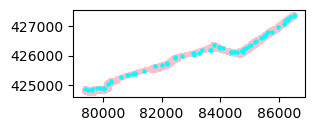

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
gdf_prp.plot(ax=ax, color='pink', markersize=5)
gdf_cpt_sel.plot(ax=ax, color='cyan', markersize=5)
plt.show()

In [6]:
create_features = dft.utils.CreateInputsML()
aggregated_features = create_features.find_closer_points(
    input_data=data_cpts_sel,
    combined_data=data_prps,
    aggregate_method=dft.utils.AggregateMethod.MEAN,
    aggregate_variable='prp',
    number_of_points=10,
    interpolate_on_independent_variable=True
)

In [7]:
# prepare feature data
for aggregated_feature in aggregated_features:
    create_features.add_features(
        input=aggregated_feature,
        variable_names=['prp'],
        use_independent_variable=True,
        use_location_as_input=(True, True, False),
    )
    create_features.add_targets(aggregated_feature, ['wrijvingsgetal'])

In [8]:
# separate feature data by training, test and validation
create_features.split_train_test_data(train_percentage=0.7, validation_percentage_on_test=0.5)

training_data = create_features.get_features_train(flatten=False)
target_data = create_features.get_targets_train(flatten=False)
test_training = create_features.get_features_test(flatten=False)
test_target = create_features.get_targets_test(flatten=False)
validation_training = create_features.get_features_validation(flatten=False)
validation_target = create_features.get_targets_validation(flatten=False)

# grmph. remove nan from training, test and validation based on the target arrays
training_data, target_data = remove_nan_training_target(training_data, target_data)
validation_training, validation_target = remove_nan_training_target(validation_training, validation_target)
test_training, test_target = remove_nan_training_target(test_training, test_target)

In [9]:
create_features.get_feature_names()

['prp', 'sondeertrajectlengte', 'location_x', 'location_y']

Text(0.5, 1.0, 'wrijvingsgetal')

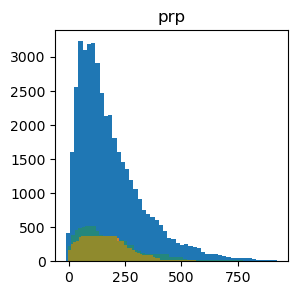

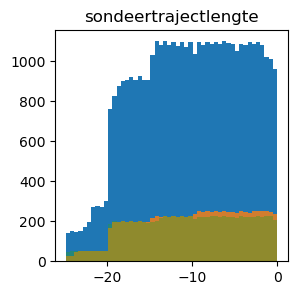

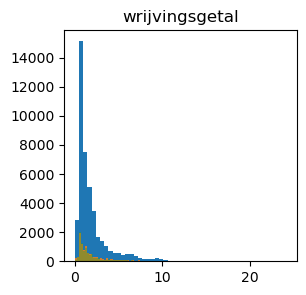

In [10]:
n_bins = 50
for i in [0, 1]:
    fig, axs = plt.subplots(1, 1, figsize=(3, 3))
    axs.hist(training_data.T[i], bins=n_bins, label='Train')
    axs.hist(test_training.T[i], bins=n_bins, alpha=0.8, label='Test')
    axs.hist(validation_training.T[i], bins=n_bins, label='Validation', alpha=0.4)
    axs.set_title(create_features.get_feature_names()[i])
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.hist(target_data, bins=n_bins, label='Train')
axs.hist(test_target, bins=n_bins, alpha=0.8, label='Test')
axs.hist(validation_target, bins=n_bins, label='Validation', alpha=0.4)
axs.set_title('wrijvingsgetal')

In [ ]:
print(f'training: {training_data.shape}\ntest: {test_training.shape}\nvalidation: {validation_training.shape}')

training: (43167, 4)
test: (9521, 4)
validation: (9065, 4)


In [ ]:
nn = dft.machine_learning.bayesian_neural_network.BayesianNeuralNetwork(
    classification=False,
    nb_hidden_layers=2,
    nb_neurons=[8, 8],
    activation_fct=dft.enumeration_classes.ActivationFunctions.sigmoid,
    optimizer=dft.enumeration_classes.Optimizer.Adadelta,
    epochs=100,
    batch=14,
    feature_names=create_features.get_feature_names(),
    learning_rate=0.0001,
    validation_features=validation_training,
    validation_targets=validation_target,
)

In [14]:
nn.train(training_data, target_data)

divide by zero encountered in divide
2022-09-16 19:56:13.618103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 19:56:13.618465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 19:56:13.618803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 19:56:13.618865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-16 19:5

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense_variational (DenseVar  (None, 8)                860       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 8)                2700      
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                             

In [16]:
nn.predict(test_training)

298/298 [==============================] - 1s 598us/step


In [17]:
nn.plot_cost_function(output_folder=Path("test_bnn"))
img = mpimg.imread(Path(r'test_bnn/performance.png'))
plt.imshow(img)

STREAM b'IHDR' 16 13
STREAM b'tEXt' 41 57
STREAM b'pHYs' 110 9
STREAM b'IDAT' 131 28327


STREAM b'IHDR' 16 13
STREAM b'tEXt' 41 57
STREAM b'pHYs' 110 9
STREAM b'IDAT' 131 55725


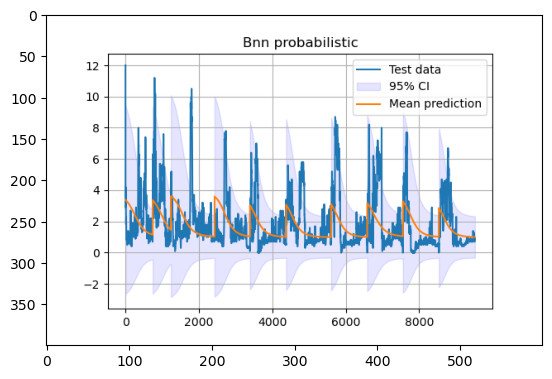

In [18]:
nn.plot_confidence_band(test_target, output_folder=Path("test_bnn"))
img = mpimg.imread(Path('test_bnn/confidence_band_bnn.png'))
imgplot = plt.imshow(img)

In [19]:
depths = np.array([prp.independent_variable.value  for prp in data_prps]).flatten()
res = np.array([prp.get_variable("prp").value  for prp in data_prps]).flatten()
x_loc = np.array([[prp.location.x] * len(prp.independent_variable.value) for prp in data_prps]).flatten()
y_loc = np.array([[prp.location.y] * len(prp.independent_variable.value) for prp in data_prps]).flatten()
data = np.array([depths, res, x_loc, y_loc])

In [20]:
data.shape

(4, 50907)

In [21]:
nn.predict(data.T)

1591/1591 [==============================] - 1s 584us/step


In [22]:
nn.prediction

array([[ 5.711404  ],
       [ 0.02806544],
       [ 4.1223927 ],
       ...,
       [-0.68091345],
       [ 1.3501801 ],
       [ 3.704103  ]], dtype=float32)

In [23]:
start = 0 
for ix, prp in enumerate(data_prps):
    spread = len(prp.independent_variable.value)
    wg_nn = nn.prediction[start:(start + spread)]
    wg_variable = Variable(label='wrijvingsgetal', value=wg_nn.flatten())
    prp.variables.append(wg_variable)
    data_prps[ix] = prp
    start += spread

In [119]:
# location_1 = Geometry(x=80833, y=425331, z=0)
# location_2 = Geometry(x=81181, y=425370, z=0)

location_1 = Geometry(x=80286, y=425057, z=0)
location_2 = Geometry(x=80254, y=425151, z=0)

# location_1 = Geometry(x=79000, y=426000, z=0)
# location_2 = Geometry(x=85000, y=429000, z=0)

In [120]:
surface_line = list(get_equidistant_points((location_1.x,location_1.y), (location_2.x,location_2.y), 100))

In [121]:
spatial_utils = SpatialUtils(TypesAhn.AHN3)
spatial_utils.get_ahn_surface_line(np.array(surface_line))

Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): 

In [122]:
spatial_utils.AHN_data = spatial_utils.AHN_data[spatial_utils.AHN_data.T[2] < 10]

In [123]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(spatial_utils.AHN_data.T[0], spatial_utils.AHN_data.T[1], spatial_utils.AHN_data.T[2])

In [124]:
plt.plot(spatial_utils.AHN_data.T[1], spatial_utils.AHN_data.T[2])

In [130]:
interpolator_slice = Nearest()
interpolator = Interpolate2DSlice()
points_2d_slice, results_2d_slice = interpolator.get_2d_slice_extra(
    location_1=location_1,
    location_2=location_2,
    data=data_cpts,
    interpolate_variable="wrijvingsgetal",
    number_of_points=100,
    number_of_independent_variable_points=120,    
    interpolation_method=InverseDistance(),  # we can define a different interpolator    
    top_surface=spatial_utils.AHN_data, #<--- deze werkt niet mee.. :(
    bottom_surface=np.array(
       [[location_1.x, location_1.y, -10], [location_2.x, location_2.y, -10]]
    ),
)

ValueError: The surface selected does not have the same slope as the points selected for the slice

In [127]:
spatial_utils.AHN_data[20::].shape

(81, 3)

In [114]:
np.array(points_2d_slice).shape

(100, 120, 3)

In [115]:
np.array(results_2d_slice).shape

(100, 120)

In [116]:
# re-arange results
for ix, points in enumerate(points_2d_slice):
    for ix2, row in enumerate(points_2d_slice[ix]):
        row.append(results_2d_slice[ix][ix2])
        points_2d_slice[ix][ix2] = row

points_2d_slice = np.array(points_2d_slice)
points_2d_slice = np.reshape(
    points_2d_slice, (points_2d_slice.shape[0] * points_2d_slice.shape[1], 4)
)

points_2d_slice = np.array(
    [points_2d_slice.T[0, :], points_2d_slice.T[2, :], points_2d_slice.T[3, :]]
).T

In [117]:
points_2d_slice

array([[ 7.90000000e+04, -1.00000000e+01,  1.65000000e+00],
       [ 7.90000000e+04, -9.91619832e+00,  2.01666667e+00],
       [ 7.90000000e+04, -9.83239664e+00,  2.01666667e+00],
       ...,
       [ 8.50000000e+04,  5.48363022e-01,  3.23333327e+00],
       [ 8.50000000e+04,  6.38519971e-01,  3.23333326e+00],
       [ 8.50000000e+04,  7.28676920e-01,  3.23333325e+00]])

locator: <matplotlib.ticker.AutoLocator object at 0x7fdcf899bd00>


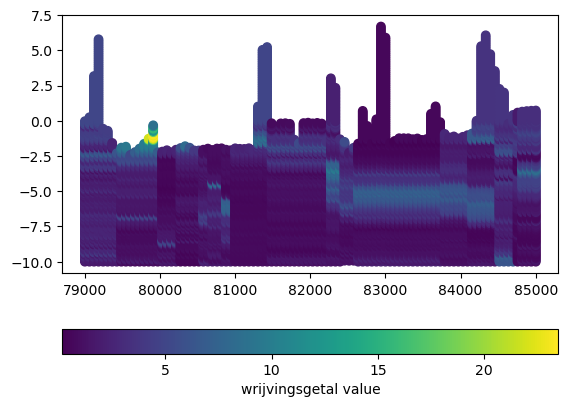

In [118]:
plt.scatter(points_2d_slice.T[0], points_2d_slice.T[1], c=points_2d_slice.T[2])
plt.colorbar(label="wrijvingsgetal value", orientation="horizontal")

In [97]:
points_2d_slice

array([[ 8.08357437e+04, -1.00000000e+01,  4.16663149e-01],
       [ 8.08357437e+04, -9.91596639e+00,  4.49998380e-01],
       [ 8.08357437e+04, -9.83193277e+00,  5.00000000e-01],
       ...,
       [ 8.11963970e+04, -1.68067227e-01,  4.81666667e+00],
       [ 8.11963970e+04, -8.40336134e-02,             nan],
       [ 8.11963970e+04,  0.00000000e+00,             nan]])

In [100]:
points_2d_slice = points_2d_slice[~np.isnan(points_2d_slice[:,2]),::]

In [101]:
cluster_model = ClusteringLayers()
cluster_model.cluster_2d_surface(points_2d_slice, k_candidates=20)

IndexError: list index out of range

In [ ]:
plt.scatter(points_2d_slice.T[0], points_2d_slice.T[1], c=points_2d_slice.T[2], alpha=0.7)
plt.colorbar(label="wrijvingsgetal value", orientation="horizontal")
for polygon in cluster_model.simplified_polygons:
    plt.plot(polygon.exterior.xy[0], polygon.exterior.xy[1])

In [ ]:
filename = "mylittle_model_default.stix"
model = DStabilityModel.create_model(cluster_model.simplified_polygons, filename, soil_list=None)

In [ ]:
def soil_type_from_IC(ic: float):
    """
    Classifies IC based on figure 22 of Robertson, 2010, page 27
    """
    if ic < 1.31:
        return {
            "name": "dense sand",
            "code": 7,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 22},
                "unsaturated_weight": {"mean": 17},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 32.5},
            },
        }
    elif ic >= 1.31 and ic < 2.05:
        return {
            "name": "silty sand",
            "code": 6,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 22},
                "unsaturated_weight": {"mean": 17},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 30},
            },
        }
    elif ic >= 2.05 and ic < 2.6:
        return {
            "name": "sandy silt",
            "code": 5,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 21},
                "unsaturated_weight": {"mean": 19},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 29},
            },
        }
    elif ic >= 2.6 and ic < 2.95:
        return {
            "name": "silty clay",
            "code": 4,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 20},
                "unsaturated_weight": {"mean": 19},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 27},
            },
        }
    elif ic >= 2.95 and ic < 3.6:
        return {
            "name": "silty clay",
            "code": 3,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 18},
                "unsaturated_weight": {"mean": 18},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 27},
            },
        }
    else:
        return {
            "name": "Organic soil",
            "code": 2,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 13},
                "unsaturated_weight": {"mean": 13},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 15},
            },
        }

In [ ]:
soils_dictionary = [soil_type_from_IC(wg * 25) for wg in cluster_model.extracted_value_per_polygon]

In [ ]:
filename = "mylittle_model_IC.stix"
model = DStabilityModel.create_model(cluster_model.simplified_polygons, filename, soils_dictionary)

In [ ]:
interpolator = Interpolate2DSlice()
points_2d_slice, results_2d_slice = interpolator.get_2d_slice_extra(
    location_1=location_1,
    location_2=location_2,
    data=data_cpts,
    interpolate_variable="conusweerstand",
    number_of_points=100,
    number_of_independent_variable_points=120,
    interpolation_method=InverseDistance()  # we can define a different interpolator
)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# plot ruwe data
for cpt in data_cpts:
    c = np.array(cpt.get_variable('conusweerstand').value)    
    ind_var = np.array(cpt.independent_variable.value)
    xs = np.ones_like(ind_var) * cpt.location.x
    ys = np.ones_like(ind_var) * cpt.location.y
    zs = -1 * ind_var + cpt.location.z
    cb = ax.scatter(xs=xs, ys=ys, zs=zs, c=c, vmax=20, s=0)

# plot geinterpoleerde data
for ix, cpt_int in enumerate(points_2d_slice):
    c = results_2d_slice[ix]
    xs = np.array(cpt_int).T[0]
    ys = np.array(cpt_int).T[1]
    zs = -1 * np.array(cpt_int).T[2] + cpt.location.z
    cb = ax.scatter(xs=xs, ys=ys, zs=zs, c=c, vmax=20)#, s=0)
    
plt.colorbar(cb)
plt.show()